In [1]:
from __future__ import print_function

import os

import numpy as np
from keras.layers import RepeatVector
from keras.layers.core import Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.models import load_model

import matplotlib.pylab as plt

np.random.seed(123)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def prepare_sequences(x_train, window_length, random_indices):
    full_sequence = x_train.flatten()
    windows = []
    outliers = []
    for window_start in range(0, len(full_sequence) - window_length + 1):
        window_end = window_start + window_length
        window_range = range(window_start, window_end)
        window = list(full_sequence[window_range])
        contain_outlier = len(set(window_range).intersection(set(random_indices))) > 0
        outliers.append(contain_outlier)
        windows.append(window)
    return np.expand_dims(np.array(windows), axis=2), outliers


def get_signal(size, outliers_size=0.01):
    sig = np.expand_dims(np.random.normal(loc=0, scale=1, size=(size, 1)), axis=1)
    if outliers_size < 1:  # percentage.
        outliers_size = int(size * outliers_size)
    random_indices = np.random.choice(range(size), size=outliers_size, replace=False)
    sig[random_indices] = np.random.randint(6, 9, 1)[0]
    return sig, random_indices


def tp_fn_fp_tn(total, expected, actual):
    tp = len(set(expected).intersection(set(actual)))
    fn = len(set(expected) - set(actual))
    fp = len(set(actual) - set(expected))
    tn = len((total - set(expected)).intersection(total - set(actual)))
    return tp, fn, fp, tn

In [3]:
window_length = 10
# select_only_last_state = False
# model_file = 'model.h5'
hidden_dim = 16

# no outliers.
signal_train, _ = get_signal(100000, outliers_size=0)
x_train, _ = prepare_sequences(signal_train, window_length, [])

# 1 percent are outliers.
signal_test, random_indices = get_signal(100000, outliers_size=0.01)
x_test, contain_outliers = prepare_sequences(signal_test, window_length, random_indices)
outlier_indices = np.where(contain_outliers)[0]





In [4]:
x_train.shape, x_test.shape, outlier_indices.shape

((99991, 10, 1), (99991, 10, 1), (9465,))

In [23]:
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model

timesteps = 10
latent_dim = 16
input_dim = 1 


inputs = Input(shape=(timesteps, input_dim))
encoded = LSTM(latent_dim)(inputs)

decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(input_dim, return_sequences=True)(decoded)

sequence_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)

In [25]:
sequence_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10, 1)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                1152      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 10, 16)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 10, 1)             72        
Total params: 1,224
Trainable params: 1,224
Non-trainable params: 0
_________________________________________________________________


In [26]:
from keras.utils import plot_model
plot_model(sequence_autoencoder,to_file='sequence_autoencoder.png', show_shapes=True, show_layer_names=True)

In [24]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10, 1)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                1152      
Total params: 1,152
Trainable params: 1,152
Non-trainable params: 0
_________________________________________________________________


In [36]:

seq_false = Sequential()
seq_false.add(LSTM(hidden_dim, input_shape=(window_length, 1), return_sequences=False))
seq_false.add(Dropout(p=0.1))
# seq_false.add(LSTM(16, return_sequences=False, activation='linear'))
seq_false.compile(loss='mse', optimizer='adam')
plot_model(seq_false,to_file='seq_false.png', show_shapes=True, show_layer_names=True)
seq_false.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 16)                1152      
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
Total params: 1,152
Trainable params: 1,152
Non-trainable params: 0
_________________________________________________________________


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.


In [5]:

m = Sequential()
#     if select_only_last_state:
#         m.add(LSTM(hidden_dim, input_shape=(window_length, 1), return_sequences=False))
#         m.add(RepeatVector(window_length))
#     else:
m.add(LSTM(hidden_dim, input_shape=(window_length, 1), return_sequences=True))
m.add(Dropout(p=0.1))
m.add(LSTM(1, return_sequences=True, activation='linear'))
m.compile(loss='mse', optimizer='adam')
m.fit(x_train, x_train, batch_size=64, nb_epoch=5, validation_data=(x_test, x_test))
# m.save(model_file)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/keras/models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 99991 samples, validate on 99991 samples
Epoch 1/5
99991/99991 [==============================] - 46s 457us/step - loss: 0.1158 - val_loss: 0.2165
Epoch 2/5
99991/99991 [==============================] - 42s 424us/step - loss: 0.0154 - val_loss: 0.1940
Epoch 3/5
99991/99991 [==============================] - 44s 438us/step - loss: 0.0116 - val_loss: 0.1668
Epoch 4/5
99991/99991 [==============================] - 43s 434us/step - loss: 0.0098 - val_loss: 0.1344
Epoch 5/5
99991/99991 [==============================] - 43s 427us/step - loss: 0.0088 - val_loss: 0.1110


In [50]:
x_train.shape, x_train[0], x_train[0][::-1]

((99991, 10, 1), (99991, 10, 1), array([[-1.0856306 ],
        [ 0.99734545],
        [ 0.2829785 ],
        [-1.50629471],
        [-0.57860025],
        [ 1.65143654],
        [-2.42667924],
        [-0.42891263],
        [ 1.26593626],
        [-0.8667404 ]]), array([[-0.8667404 ],
        [ 1.26593626],
        [-0.42891263],
        [-2.42667924],
        [ 1.65143654],
        [-0.57860025],
        [-1.50629471],
        [ 0.2829785 ],
        [ 0.99734545],
        [-1.0856306 ]]))

In [52]:
x_train_rev = []
x_test_rev = []
for item in x_train:
    x_train_rev.append(item[::-1])
for item in x_test:
    x_test_rev.append(item[::-1])
x_train_rev = np.array(x_train_rev)
x_test_rev = np.array(x_test_rev)
x_train_rev.shape, x_test_rev.shape, x_test.shape


((99991, 10, 1), (99991, 10, 1), (99991, 10, 1))

In [54]:
m_reverse = Sequential()
m_reverse.add(LSTM(hidden_dim, input_shape=(window_length, 1), return_sequences=True))
m_reverse.add(Dropout(p=0.1))
m_reverse.add(LSTM(1, return_sequences=True, activation='linear'))
m_reverse.compile(loss='mse', optimizer='adam')
m_reverse.fit(x_train, x_train_rev, batch_size=64, nb_epoch=5, validation_data=(x_test, x_test_rev))

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/keras/models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 99991 samples, validate on 99991 samples
Epoch 1/5
99991/99991 [==============================] - 47s 465us/step - loss: 0.8764 - val_loss: 1.4220
Epoch 2/5
99991/99991 [==============================] - 44s 439us/step - loss: 0.8257 - val_loss: 1.3722
Epoch 3/5
99991/99991 [==============================] - 44s 442us/step - loss: 0.8065 - val_loss: 1.3399
Epoch 4/5
99991/99991 [==============================] - 44s 440us/step - loss: 0.7898 - val_loss: 1.3246
Epoch 5/5
99991/99991 [==============================] - 44s 436us/step - loss: 0.7747 - val_loss: 1.3140


In [60]:
m_reverse = Sequential()
m_reverse.add(LSTM(hidden_dim, input_shape=(window_length, 1), return_sequences=True))
m_reverse.add(Dropout(p=0.1))
m_reverse.add(LSTM(1, return_sequences=True, activation='linear'))
m_reverse.compile(loss='mse', optimizer='adam')
m_reverse.fit(x_train, x_train_rev, batch_size=64, nb_epoch=50, validation_data=(x_test, x_test_rev))

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/keras/models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 99991 samples, validate on 99991 samples
Epoch 1/50
99991/99991 [==============================] - 46s 461us/step - loss: 0.8785 - val_loss: 1.4146
Epoch 2/50
99991/99991 [==============================] - 44s 435us/step - loss: 0.8292 - val_loss: 1.3616
Epoch 3/50
99991/99991 [==============================] - 43s 432us/step - loss: 0.8131 - val_loss: 1.3351
Epoch 4/50
99991/99991 [==============================] - 43s 434us/step - loss: 0.8012 - val_loss: 1.3425
Epoch 5/50
99991/99991 [==============================] - 43s 434us/step - loss: 0.7922 - val_loss: 1.3485
Epoch 6/50
99991/99991 [==============================] - 43s 431us/step - loss: 0.7848 - val_loss: 1.3458
Epoch 7/50
99991/99991 [==============================] - 43s 433us/step - loss: 0.7785 - val_loss: 1.3406
Epoch 8/50
99991/99991 [==============================] - 43s 431us/step - loss: 0.7726 - val_loss: 1.3267
Epoch 9/50
99991/99991 [==============================] - 44s 435us/step - loss: 0.7654 - val_

In [63]:
#50 iter
m = m_reverse
pred_x_test = m.predict(x_test_rev)
mae_of_predictions = np.squeeze(np.max(np.square(pred_x_test - x_test_rev), axis=1))
mae_threshold = np.mean(mae_of_predictions) + np.std(mae_of_predictions)  # can use a running mean instead.
actual = np.where(mae_of_predictions > mae_threshold)[0]

tp, fn, fp, tn = tp_fn_fp_tn(set(range(len(pred_x_test))), outlier_indices, actual)
precision = float(tp) / (tp + fp)
hit_rate = float(tp) / (tp + fn)
accuracy = float(tp + tn) / (tp + tn + fp + fn)

print('precision = {}, hit_rate = {}, accuracy = {}'.format(precision, hit_rate, accuracy))
tp, fn, fp, tn

precision = 0.9956851189223321, hit_rate = 0.9995773903856313, accuracy = 0.9995499594963547


(9461, 4, 41, 90485)

In [55]:
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model

timesteps = 10
latent_dim = 16
input_dim = 1 


inputs = Input(shape=(timesteps, input_dim))
encoded = LSTM(latent_dim)(inputs)

decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(input_dim, return_sequences=True)(decoded)

sequence_autoencoder_rev = Model(inputs, decoded)
encoder = Model(inputs, encoded)
sequence_autoencoder_rev.compile(loss='mse', optimizer='adam')
sequence_autoencoder_rev.fit(x_train, x_train_rev, batch_size=64, nb_epoch=5, validation_data=(x_test, x_test_rev))

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:18: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 99991 samples, validate on 99991 samples
Epoch 1/5
99991/99991 [==============================] - 46s 458us/step - loss: 0.8890 - val_loss: 1.4415
Epoch 2/5
99991/99991 [==============================] - 43s 433us/step - loss: 0.8711 - val_loss: 1.4325
Epoch 3/5
99991/99991 [==============================] - 43s 431us/step - loss: 0.8644 - val_loss: 1.4235
Epoch 4/5
99991/99991 [==============================] - 43s 428us/step - loss: 0.8577 - val_loss: 1.4111
Epoch 5/5
99991/99991 [==============================] - 43s 427us/step - loss: 0.8486 - val_loss: 1.3946


In [61]:
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model

timesteps = 10
latent_dim = 16
input_dim = 1 


inputs = Input(shape=(timesteps, input_dim))
encoded = LSTM(latent_dim)(inputs)

decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(input_dim, return_sequences=True)(decoded)

sequence_autoencoder_rev = Model(inputs, decoded)
encoder = Model(inputs, encoded)
sequence_autoencoder_rev.compile(loss='mse', optimizer='adam')
sequence_autoencoder_rev.fit(x_train, x_train_rev, batch_size=64, nb_epoch=50, validation_data=(x_test, x_test_rev))

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:18: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 99991 samples, validate on 99991 samples
Epoch 1/50
99991/99991 [==============================] - 45s 452us/step - loss: 0.8912 - val_loss: 1.4426
Epoch 2/50
99991/99991 [==============================] - 42s 422us/step - loss: 0.8712 - val_loss: 1.4261
Epoch 3/50
99991/99991 [==============================] - 42s 422us/step - loss: 0.8601 - val_loss: 1.4219
Epoch 4/50
99991/99991 [==============================] - 42s 420us/step - loss: 0.8556 - val_loss: 1.4124
Epoch 5/50
99991/99991 [==============================] - 43s 429us/step - loss: 0.8526 - val_loss: 1.4155
Epoch 6/50
99991/99991 [==============================] - 43s 429us/step - loss: 0.8501 - val_loss: 1.4121
Epoch 7/50
99991/99991 [==============================] - 43s 427us/step - loss: 0.8472 - val_loss: 1.4017
Epoch 8/50
99991/99991 [==============================] - 43s 426us/step - loss: 0.8448 - val_loss: 1.3988
Epoch 9/50
99991/99991 [==============================] - 43s 428us/step - loss: 0.8426 - val_

In [62]:
#50 iter
m = sequence_autoencoder_rev
pred_x_test = m.predict(x_test_rev)
mae_of_predictions = np.squeeze(np.max(np.square(pred_x_test - x_test_rev), axis=1))
mae_threshold = np.mean(mae_of_predictions) + np.std(mae_of_predictions)  # can use a running mean instead.
actual = np.where(mae_of_predictions > mae_threshold)[0]

tp, fn, fp, tn = tp_fn_fp_tn(set(range(len(pred_x_test))), outlier_indices, actual)
precision = float(tp) / (tp + fp)
hit_rate = float(tp) / (tp + fn)
accuracy = float(tp + tn) / (tp + tn + fp + fn)

print('precision = {}, hit_rate = {}, accuracy = {}'.format(precision, hit_rate, accuracy))
tp, fn, fp, tn

precision = 1.0, hit_rate = 1.0, accuracy = 1.0


(9465, 0, 0, 90526)

In [27]:
sequence_autoencoder.compile(loss='mse', optimizer='adam')
sequence_autoencoder.fit(x_train, x_train, batch_size=64, nb_epoch=5, validation_data=(x_test, x_test))

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 99991 samples, validate on 99991 samples
Epoch 1/5
99991/99991 [==============================] - 44s 444us/step - loss: 0.8887 - val_loss: 1.4344
Epoch 2/5
99991/99991 [==============================] - 43s 427us/step - loss: 0.8695 - val_loss: 1.4408
Epoch 3/5
99991/99991 [==============================] - 43s 426us/step - loss: 0.8651 - val_loss: 1.4417
Epoch 4/5
99991/99991 [==============================] - 42s 424us/step - loss: 0.8610 - val_loss: 1.4331
Epoch 5/5
99991/99991 [==============================] - 44s 436us/step - loss: 0.8562 - val_loss: 1.4276


In [57]:
m = m_reverse
pred_x_test = m.predict(x_test_rev)
mae_of_predictions = np.squeeze(np.max(np.square(pred_x_test - x_test_rev), axis=1))
mae_threshold = np.mean(mae_of_predictions) + np.std(mae_of_predictions)  # can use a running mean instead.
actual = np.where(mae_of_predictions > mae_threshold)[0]

tp, fn, fp, tn = tp_fn_fp_tn(set(range(len(pred_x_test))), outlier_indices, actual)
precision = float(tp) / (tp + fp)
hit_rate = float(tp) / (tp + fn)
accuracy = float(tp + tn) / (tp + tn + fp + fn)

print('precision = {}, hit_rate = {}, accuracy = {}'.format(precision, hit_rate, accuracy))
tp, fn, fp, tn

precision = 0.9996831432192649, hit_rate = 1.0, accuracy = 0.999969997299757


(9465, 0, 3, 90523)

In [58]:
m = sequence_autoencoder_rev
pred_x_test = m.predict(x_test_rev)
mae_of_predictions = np.squeeze(np.max(np.square(pred_x_test - x_test_rev), axis=1))
mae_threshold = np.mean(mae_of_predictions) + np.std(mae_of_predictions)  # can use a running mean instead.
actual = np.where(mae_of_predictions > mae_threshold)[0]

tp, fn, fp, tn = tp_fn_fp_tn(set(range(len(pred_x_test))), outlier_indices, actual)
precision = float(tp) / (tp + fp)
hit_rate = float(tp) / (tp + fn)
accuracy = float(tp + tn) / (tp + tn + fp + fn)

print('precision = {}, hit_rate = {}, accuracy = {}'.format(precision, hit_rate, accuracy))
tp, fn, fp, tn

precision = 0.9997887398331045, hit_rate = 1.0, accuracy = 0.999979998199838


(9465, 0, 2, 90524)

In [ ]:
m = sequence_autoencoder
pred_x_test = m.predict(x_test)
mae_of_predictions = np.squeeze(np.max(np.square(pred_x_test - x_test), axis=1))
mae_threshold = np.mean(mae_of_predictions) + np.std(mae_of_predictions)  # can use a running mean instead.
actual = np.where(mae_of_predictions > mae_threshold)[0]

tp, fn, fp, tn = tp_fn_fp_tn(set(range(len(pred_x_test))), outlier_indices, actual)
precision = float(tp) / (tp + fp)
hit_rate = float(tp) / (tp + fn)
accuracy = float(tp + tn) / (tp + tn + fp + fn)

print('precision = {}, hit_rate = {}, accuracy = {}'.format(precision, hit_rate, accuracy))

In [37]:
tp, fn, fp, tn

(9465, 0, 0, 90526)

In [ ]:
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model

timesteps = 10
latent_dim = 16
input_dim = 1 


inputs = Input(shape=(timesteps, input_dim))
encoded = LSTM(latent_dim)(inputs)

decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(input_dim, return_sequences=True)(decoded)

sequence_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)

In [6]:
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 16)            1152      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 16)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 1)             72        
Total params: 1,224
Trainable params: 1,224
Non-trainable params: 0
_________________________________________________________________


In [21]:
from keras.utils import plot_model
plot_model(m,to_file='time_series_anomaly.png', show_shapes=True, show_layer_names=True)

In [7]:
pred_x_test = m.predict(x_test)
mae_of_predictions = np.squeeze(np.max(np.square(pred_x_test - x_test), axis=1))
mae_threshold = np.mean(mae_of_predictions) + np.std(mae_of_predictions)  # can use a running mean instead.
actual = np.where(mae_of_predictions > mae_threshold)[0]

tp, fn, fp, tn = tp_fn_fp_tn(set(range(len(pred_x_test))), outlier_indices, actual)
precision = float(tp) / (tp + fp)
hit_rate = float(tp) / (tp + fn)
accuracy = float(tp + tn) / (tp + tn + fp + fn)

print('precision = {}, hit_rate = {}, accuracy = {}'.format(precision, hit_rate, accuracy))

precision = 1.0, hit_rate = 1.0, accuracy = 1.0


In [8]:
#change max to sum
pred_x_test = m.predict(x_test)
mae_of_predictions = np.squeeze(np.sum(np.square(pred_x_test - x_test), axis=1))
mae_threshold = np.mean(mae_of_predictions) + np.std(mae_of_predictions)  # can use a running mean instead.
actual = np.where(mae_of_predictions > mae_threshold)[0]

tp, fn, fp, tn = tp_fn_fp_tn(set(range(len(pred_x_test))), outlier_indices, actual)
precision = float(tp) / (tp + fp)
hit_rate = float(tp) / (tp + fn)
accuracy = float(tp + tn) / (tp + tn + fp + fn)

print('precision = {}, hit_rate = {}, accuracy = {}'.format(precision, hit_rate, accuracy))

precision = 1.0, hit_rate = 1.0, accuracy = 1.0


In [9]:
np.sum(np.square(pred_x_test - x_test), axis=1).shape, actual.shape

((99991, 1), (9465,))

In [10]:
np.square(pred_x_test - x_test).shape, np.max(np.square(pred_x_test - x_test), axis=1).shape

((99991, 10, 1), (99991, 1))

In [11]:
np.square(pred_x_test - x_test)[0:2]

array([[[7.44124097e-05],
        [1.10928596e-05],
        [3.95306851e-05],
        [4.13530736e-05],
        [7.63171703e-05],
        [3.30009109e-06],
        [4.40931751e-07],
        [6.57127885e-06],
        [5.26938753e-06],
        [2.77666610e-05]],

       [[1.09569456e-05],
        [1.10938689e-04],
        [3.46502364e-05],
        [8.88452243e-05],
        [5.09985431e-06],
        [1.03655578e-07],
        [8.36984237e-06],
        [5.31216287e-06],
        [2.77471913e-05],
        [7.02508353e-05]]])

In [12]:
 np.sum(np.sum(np.square(pred_x_test - x_test), axis=1))/len(x_test)/10

0.1110243441366291

In [13]:
 np.sum(np.square(pred_x_test - x_test), axis=1)[0:2], mae_of_predictions

(array([[0.00028605],
        [0.00036227]]),
 array([0.00028605, 0.00036227, 0.00049118, ..., 0.00048827, 0.00064475,
        0.00047547]))

In [14]:
 np.max(np.square(pred_x_test - x_test), axis=1)[0:2], mae_of_predictions

(array([[7.63171703e-05],
        [1.10938689e-04]]),
 array([0.00028605, 0.00036227, 0.00049118, ..., 0.00048827, 0.00064475,
        0.00047547]))

In [15]:
pred_x_test.shape, mae_of_predictions.shape, actual.shape

((99991, 10, 1), (99991,), (9465,))

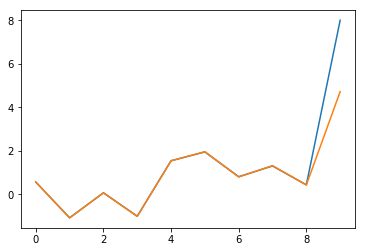

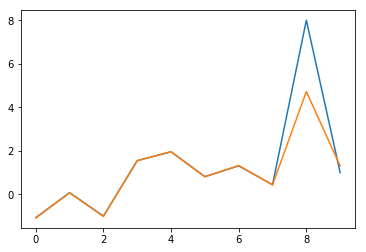

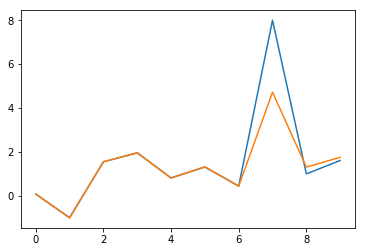

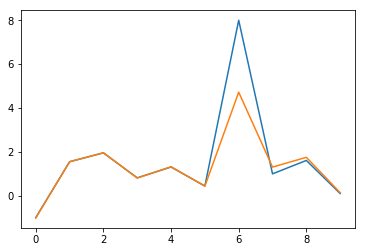

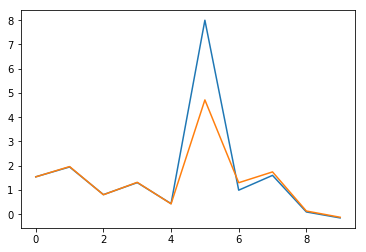

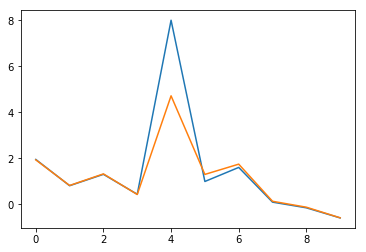

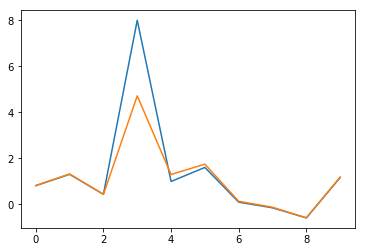

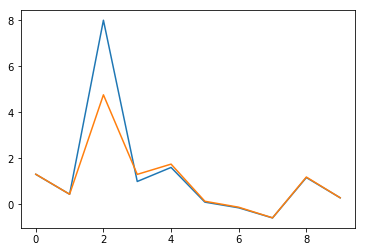

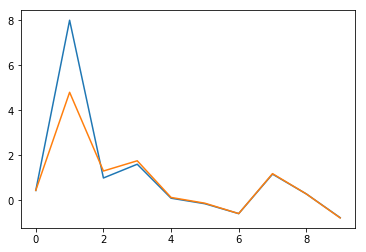

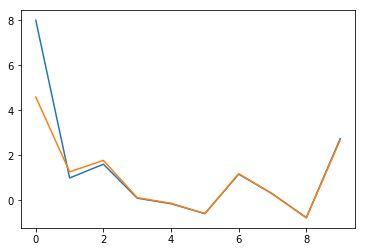

In [16]:
for index in outlier_indices[0:10]:
    plt.plot(x_test[index])
    plt.plot(pred_x_test[index])
    plt.show()

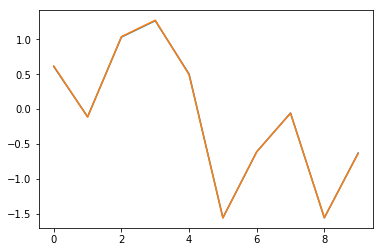

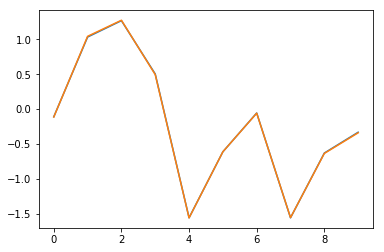

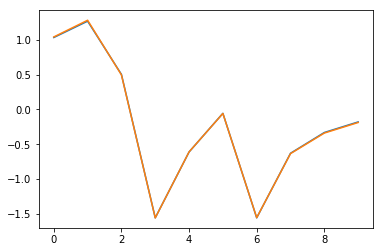

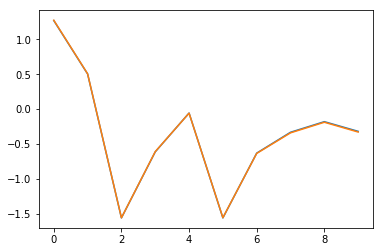

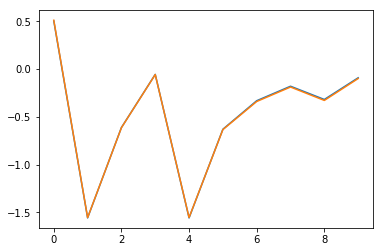

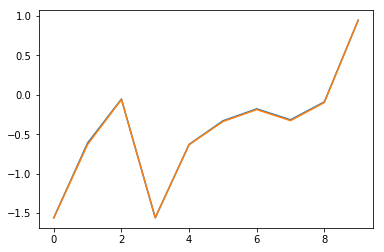

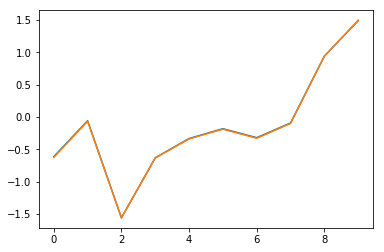

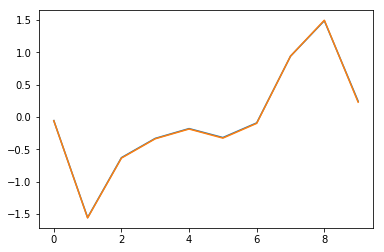

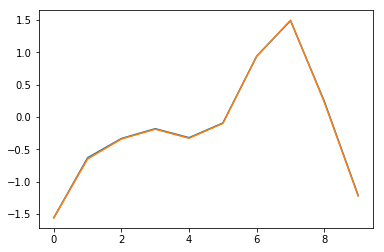

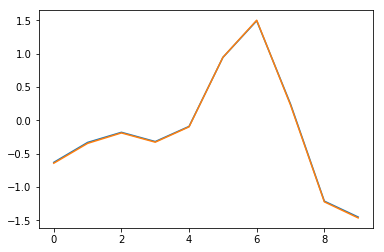

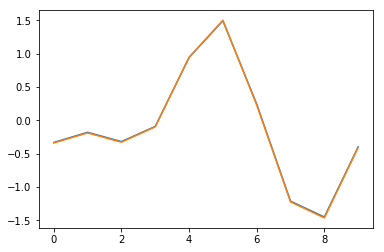

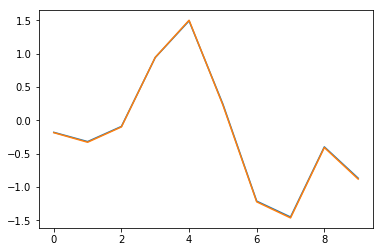

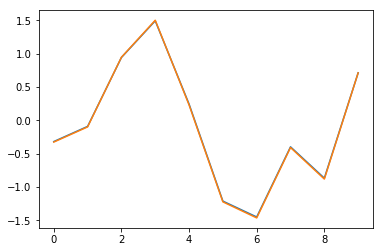

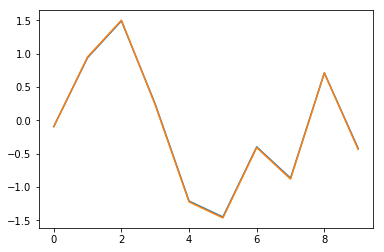

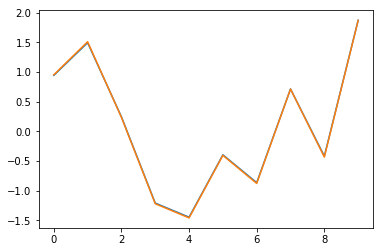

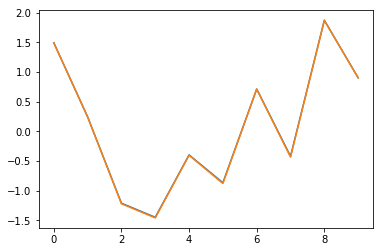

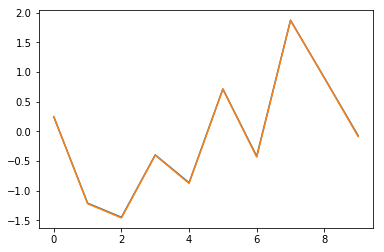

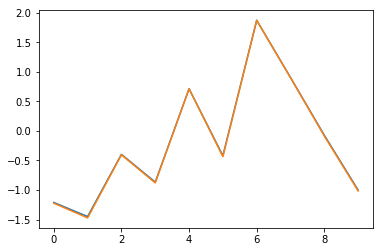

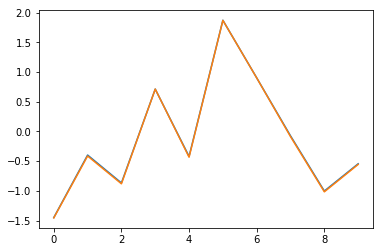

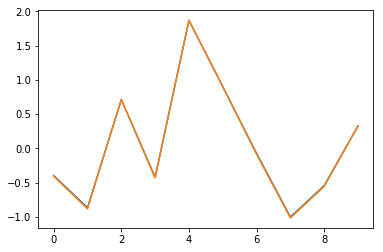

In [17]:
for index in range(0,20):
    if index not in outlier_indices:
        plt.plot(x_test[index])
        plt.plot(pred_x_test[index])
        plt.show()


In [18]:
m.get_config()

[{'class_name': 'LSTM',
  'config': {'activation': 'tanh',
   'activity_regularizer': None,
   'batch_input_shape': (None, 10, 1),
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'bias_regularizer': None,
   'dropout': 0.0,
   'dtype': 'float32',
   'go_backwards': False,
   'implementation': 1,
   'kernel_constraint': None,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'distribution': 'uniform',
     'mode': 'fan_avg',
     'scale': 1.0,
     'seed': None}},
   'kernel_regularizer': None,
   'name': 'lstm_1',
   'recurrent_activation': 'hard_sigmoid',
   'recurrent_constraint': None,
   'recurrent_dropout': 0.0,
   'recurrent_initializer': {'class_name': 'Orthogonal',
    'config': {'gain': 1.0, 'seed': None}},
   'recurrent_regularizer': None,
   'return_sequences': True,
   'return_state': False,
   'stateful': False,
   'trainable': True,
   'unit_forget_bias': True,
   'units': 16,
   'unroll': False,
   'use

In [19]:
all_weights = m.get_weights()
for item in all_weights:
    print (item.shape)

(1, 64)
(16, 64)
(64,)
(16, 4)
(1, 4)
(4,)
